In [118]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain

In [34]:
def build_assessment_json(assessment):
    regex_result = re.findall("'metric': '.*?', 'score': '.*?'", assessment)
    assessment_list = []
    for result in regex_result:
        result = result.replace("\'", "\"")
        assessment_dict = json.loads("{"+result+"}")
        assessment_list.append(assessment_dict)
    return assessment_list

In [35]:
def get_metrics_from_result(assessment_result):
    return [item.get('metric') for item in assessment_result]

def get_scores_from_result(assessment_result):
    return [int(item.get('score')) for item in assessment_result]

In [128]:
def get_principle_from_metric_fairchecker(metric):
    if metric.startswith('F'):
        return 'findable'
    elif metric.startswith('A'):
        return 'accessible'
    elif metric.startswith('I'):
        return 'interoperable'
    else:
        return 'reusable'

In [135]:
def get_principle_from_metric_fuji(metric):
    if metric.startswith("FsF-F"):
        return "findable"
    elif metric.startswith("FsF-A"):
        return "accessible"
    elif metric.startswith("FsF-I"):
        return "interoperable"
    else:
        return "reusable"

In [74]:
def expand_fcheck_df(df):
    df_exp = pd.DataFrame()
    df_exp["comparison"] = list(chain.from_iterable([[x]*11 for x in df["comparisons"]]))
    df_exp["doi"] = list(chain.from_iterable([[x]*11 for x in df["doi"]]))
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["FAIR_assessment"]]))
    df_exp["score_earned"] = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in df["FAIR_assessment"]]))
    df_exp["score_total"] = list(chain.from_iterable([[2]*11 for x in df["comparisons"]]))
    return df_exp

# Comparing comparisons assessments

In [130]:
fcheck_comp_doi_df = pd.read_csv("assessed_data/comparison_doi_df_FAIRChecker_assessment2023-03-29.csv", index_col=0)
fcheck_comp_url_df = pd.read_csv("assessed_data/comparison_orkg_df_FAIRChecker_assessment2023-03-29.csv", index_col=0)

In [131]:
print(fcheck_comp_doi_df["assessment_status_code"].value_counts())
print(fcheck_comp_url_df["assessment_status_code"].value_counts())
fcheck_comp_url_df = fcheck_comp_url_df[fcheck_comp_url_df["assessment_status_code"]==200].reset_index(drop=True)

200    294
Name: assessment_status_code, dtype: int64
200    975
500    173
504      1
Name: assessment_status_code, dtype: int64


In [132]:
fcheck_comp_doi_df = fcheck_comp_doi_df.drop(labels=["assessment_status_code"], axis=1)
fcheck_comp_doi_df["FAIR_assessment"] = fcheck_comp_doi_df["FAIR_assessment"].map(lambda x: build_assessment_json(x))
fcheck_comp_doi_df = expand_fcheck_df(fcheck_comp_doi_df)
fcheck_comp_doi_df["score_percent"] = fcheck_comp_doi_df.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fcheck_comp_url_df = fcheck_comp_url_df.drop(labels=["assessment_status_code"], axis=1)
fcheck_comp_url_df["FAIR_assessment"] = fcheck_comp_url_df["FAIR_assessment"].map(lambda x: build_assessment_json(x))
fcheck_comp_url_df = expand_fcheck_df(fcheck_comp_url_df)
fcheck_comp_url_df["score_percent"] = fcheck_comp_url_df.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)

In [133]:
fcheck_comp_doi_df_principle = fcheck_comp_doi_df
fcheck_comp_doi_df_principle["principle"] = fcheck_comp_doi_df_principle["metric"].map(lambda x: get_principle_from_metric_fairchecker(x))
fcheck_comp_doi_df_principle = fcheck_comp_doi_df_principle.groupby("principle").agg({"score_earned": "mean", "score_total": "mean"}).reset_index()
fcheck_comp_doi_df_principle["score_percent"] = fcheck_comp_doi_df_principle.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fcheck_comp_doi_df_principle['principle'] = pd.Categorical(fcheck_comp_doi_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
fcheck_comp_doi_df_principle = fcheck_comp_doi_df_principle.sort_values('principle')
fcheck_comp_url_df_principle = fcheck_comp_url_df
fcheck_comp_url_df_principle["principle"] = fcheck_comp_url_df_principle["metric"].map(lambda x: get_principle_from_metric_fairchecker(x))
fcheck_comp_url_df_principle = fcheck_comp_url_df_principle.groupby("principle").agg({"score_earned": "mean", "score_total": "mean"}).reset_index()
fcheck_comp_url_df_principle["score_percent"] = fcheck_comp_url_df_principle.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fcheck_comp_url_df_principle['principle'] = pd.Categorical(fcheck_comp_url_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
fcheck_comp_url_df_principle = fcheck_comp_url_df_principle.sort_values('principle')

____________________________________________________

In [134]:
fuji_comp_doi_df = pd.read_csv("assessed_data/comparison_doi_df_F-UJI_assessment.csv", index_col=0)
fuji_comp_url_df = pd.read_csv("assessed_data/comparison_url_df_F-UJI_assessment.csv", index_col=0)

In [127]:
fuji_comp_doi_df

,comparison,doi,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F1-01D,1,1
1,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F1-02D,1,1
2,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F2-01M,2,2
3,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F3-01M,0,1
4,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FsF-F4-01M,2,2
...,...,...,...,...,...
4699,http://orkg.org/orkg/resource/R576876,10.48366/r576876,FsF-R1.2-01M,1,2
4700,http://orkg.org/orkg/resource/R576876,10.48366/r576876,FsF-R1.3-01M,0,1
4701,http://orkg.org/orkg/resource/R576876,10.48366/r576876,FsF-R1.3-02D,0,1
4702,http://orkg.org/orkg/resource/R576876,10.48366/r576876,FsF-A1-03D,0,1


In [136]:
fuji_comp_doi_df_principle = fuji_comp_doi_df
fuji_comp_doi_df_principle["principle"] = fuji_comp_doi_df_principle["metric"].map(lambda x: get_principle_from_metric_fuji(x))
fuji_comp_doi_df_principle = fuji_comp_doi_df_principle.groupby("principle").agg({"score_earned": "mean", "score_total": "mean"}).reset_index()
fuji_comp_doi_df_principle["score_percent"] = fuji_comp_doi_df_principle.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fuji_comp_doi_df_principle['principle'] = pd.Categorical(fuji_comp_doi_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
fuji_comp_doi_df_principle = fuji_comp_doi_df_principle.sort_values('principle')
fuji_comp_url_df_principle = fuji_comp_url_df
fuji_comp_url_df_principle["principle"] = fuji_comp_url_df_principle["metric"].map(lambda x: get_principle_from_metric_fuji(x))
fuji_comp_url_df_principle = fuji_comp_url_df_principle.groupby("principle").agg({"score_earned": "mean", "score_total": "mean"}).reset_index()
fuji_comp_url_df_principle["score_percent"] = fuji_comp_url_df_principle.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fuji_comp_url_df_principle['principle'] = pd.Categorical(fuji_comp_url_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
fuji_comp_url_df_principle = fuji_comp_url_df_principle.sort_values('principle')

________________________________________________________

# A plot comparing the total FAIRness score across all evaluated assessment tools considering DOI and ORKG resource URL assessment

In [ ]:
# Total FAIRness score for DOI & ORKG URL per evaluated Tool

# A plot comparing the FAIRness scores for the FAIR principles across all evaluated assessment tools considering DOI and ORKG resource URL assessment

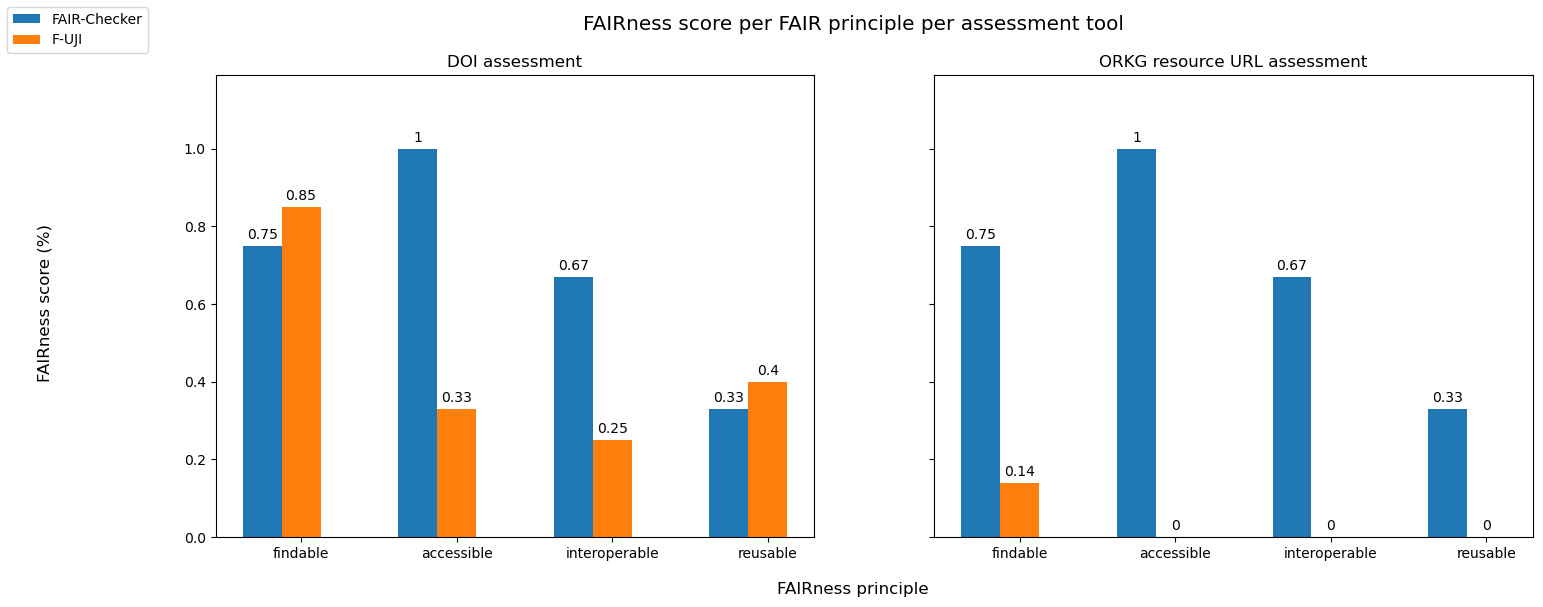

In [184]:
principles = ("findable", "accessible", "interoperable", "reusable")
fairscores_doi = {
    "FAIR-Checker": tuple(fcheck_comp_doi_df_principle["score_percent"].round(decimals=2)),
    "F-UJI": tuple(fuji_comp_doi_df_principle["score_percent"].round(decimals=2))
}
fairscores_url = {
    "FAIR-Checker": tuple(fcheck_comp_url_df_principle["score_percent"].round(decimals=2)),
    "F-UJI": tuple(fuji_comp_url_df_principle["score_percent"].round(decimals=2))
}

x = np.arange(len(principles))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(1,2, sharey=True, figsize=(17, 6))
for attribute, measurement in fairscores_doi.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute)
    ax[0].bar_label(rects, padding=3)
    multiplier += 1

multiplier = 0
for attribute, measurement in fairscores_url.items():
    offset = width * multiplier
    rects = ax[1].bar(x + offset, measurement, width, label=attribute)
    ax[1].bar_label(rects, padding=3)
    multiplier += 1

ax[0].set_xticks(x + width, principles)
ax[0].set_ylim(0, 1.19)
ax[0].title.set_text("DOI assessment")
ax[1].set_xticks(x + width, principles)
ax[1].title.set_text("ORKG resource URL assessment")

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left")
fig.supylabel("FAIRness score (%)")
fig.supxlabel("FAIRness principle")
fig.suptitle("FAIRness score per FAIR principle per assessment tool", fontsize="x-large")
plt.show()